In [7]:
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
from copy import deepcopy
from matplotlib.animation import FuncAnimation, FFMpegWriter
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML 
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
%matplotlib inline

In [3]:
base_path = '/home/rohan/Remote-AI/'
for gt in ['ttype','ttype33','consensus']:
    print(f'\n{gt} ====')
    for ld in [3,5,10]:
        best_acc_list = []
        for cv in np.arange(0,44,1):
            R = pd.read_csv(base_path+f'/dat/result/E_classifiers/logs/v1_gt_{gt:s}_bs_200_se_500_ne_1000_ld_{ld:d}_cv_{cv:d}_ri_0.csv')
            best_acc_list.append(np.max(R['val_acc'].values))
        print('latent dim: {:02d} mean: {:0.3f} sd: {:0.3f}'.format(ld, np.mean(best_acc_list), np.std(best_acc_list)))


ttype ====
latent dim: 03 mean: 0.505 sd: 0.038
latent dim: 05 mean: 0.564 sd: 0.041
latent dim: 10 mean: 0.581 sd: 0.042

ttype33 ====
latent dim: 03 mean: 0.713 sd: 0.039
latent dim: 05 mean: 0.739 sd: 0.037
latent dim: 10 mean: 0.754 sd: 0.038

consensus ====
latent dim: 03 mean: 0.535 sd: 0.057
latent dim: 05 mean: 0.626 sd: 0.065
latent dim: 10 mean: 0.639 sd: 0.052


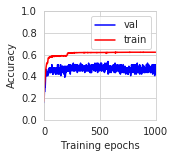

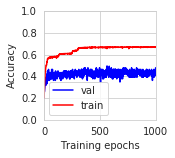

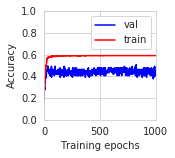

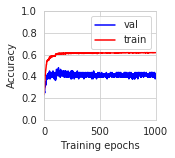

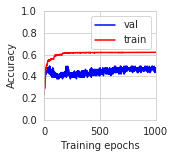

In [4]:
best_acc_list = []
ld = 3
for cv in [0,1,2,3,4]:
    R = pd.read_csv(base_path+f'/dat/result/E_classifiers/logs/v1_gt_consensus_bs_200_se_500_ne_1000_ld_{ld:d}_cv_{cv:d}_ri_0.csv')
    plt.figure(figsize = (2,2))
    plt.plot(R['val_acc'].values,'-b',label='val')
    plt.plot(R['train_acc'].values,'-r',label='train')
    ax = plt.gca()
    ax.set_ylim([0,1])
    ax.set_xlim([0,1000])
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Training epochs')
    plt.legend()

In [5]:
cv = 43
ld = 3
gt='ttype'
base_path = '/home/rohan/Remote-AI/'
R = pd.read_csv(base_path+f'/dat/result/E_classifiers/logs/v1_gt_{gt}_bs_200_se_500_ne_1000_ld_{ld:d}_cv_{cv:d}_ri_0.csv')
D = sio.loadmat(base_path+f'dat/result/E_classifiers/best_v1_gt_{gt}_bs_200_se_500_ne_1000_ld_{ld:d}_cv_{cv:d}_ri_0-summary',squeeze_me=True)
O = sio.loadmat(base_path+'dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat',squeeze_me=True)
ind = np.argmax(R['val_acc'].values)
e = R['val_epoch'].values[ind]
x = R['val_acc'].values[ind]
print(f'val. accuracy: {x:0.3f} epoch {e}')

val. accuracy: 0.471 epoch 166


#### Representation
$z_e$ for encoder network trained with only ttype classification loss:

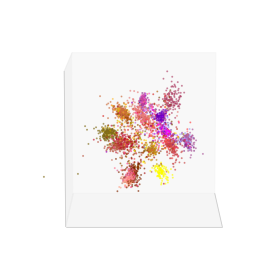

In [6]:
%matplotlib inline
xlims,ylims,zlims=(-3,3),(-3,3),(-3,3)
padval = 10
fontsizeval = 10
plt.ion()
fig = plt.figure(figsize=(4,4))    
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(D['zE'][:,0], D['zE'][:,1], D['zE'][:,2],s=1,alpha=0.5,c=O['cluster_color'])
#sc2 = ax.scatter(zTolias[:,0], zTolias[:,1], zTolias[:,2],s=10,alpha=1,c='r')


ax.set_xticks([])
ax.set_zticks([])
ax.set_yticks([])

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')

ax.set_xlim(xlims[0],xlims[1])
ax.set_ylim(ylims[0],ylims[1])
ax.set_zlim(zlims[0],zlims[1])

plt.axis('on')
ax.set_frame_on(False)
plt.tight_layout()

ax.set_title(r'',pad=padval,fontsize=fontsizeval)
fig = plt.gcf()

def update(i):
    ax.view_init(elev=10., azim=i)
    fig.canvas.draw()
    fig.canvas.flush_events()
    return

anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50)
#HTML(anim.to_html5_video())

In [1]:
from utils.tree_helpers import get_merged_ordered_classes
import pandas as pd
import scipy.io as sio

htree_file = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/dend_RData_Tree_20181220.csv'
base_path = '/home/rohan/Remote-AI/'

In [2]:
O = sio.loadmat(base_path+'dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat',squeeze_me=True)
ld = 3

df = {}
df['val_acc']=[]
df['n_components']=[]

for n_classes in np.arange(5,61,5):
    pred_list = []
    gt_list = []
    
    #Get merged ground truth labels
    gt, _   = get_merged_ordered_classes(data_labels=O['cluster'],htree_file=htree_file, n_required_classes=n_classes)

    #Look up list for original and merged label
    ref = list(set(zip(O['cluster'],gt)))
    n_components = np.unique(gt).size
    
    for cv in range(44):
        
        D = sio.loadmat(base_path+f'dat/result/E_classifiers/best_v1_gt_ttype_bs_200_se_500_ne_1000_ld_{ld:d}_cv_{cv:d}_ri_0-summary.mat', squeeze_me=True)
        ind = D['val_ind'].copy()
        
        #Clean up format of the strings in the label array
        pred = D['pred_E_cat'].copy().tolist()
        pred = [x.lstrip() for x in pred]
        pred = [x.rstrip() for x in pred]
        pred = np.array(pred)
        pred = pred.astype(np.object_).copy()
        
        #Obtain merged label for the prediction:
        for orig_lbl,merged_lbl in ref:
            pred[pred==orig_lbl]=merged_lbl

        pred_list.append(pred[ind])
        gt_list.append(gt[ind])
            
        df['val_acc'].append(np.sum(pred[ind]==gt[ind])/ind.size)
        df['n_components'].append(n_components)

    pred_arr = np.concatenate(pred_list)
    gt_arr = np.concatenate(gt_list)
    acc = np.sum(gt_arr==pred_arr)/pred_arr.size

Performed 48 merges. Remaining classes in data = 5
Performed 43 merges. Remaining classes in data = 10
Performed 39 merges. Remaining classes in data = 21
Performed 39 merges. Remaining classes in data = 21
Performed 35 merges. Remaining classes in data = 25
Performed 30 merges. Remaining classes in data = 30
Performed 25 merges. Remaining classes in data = 35
Performed 19 merges. Remaining classes in data = 40
Performed 14 merges. Remaining classes in data = 45
Performed 9 merges. Remaining classes in data = 50
Performed 4 merges. Remaining classes in data = 55
Performed 0 merges. Remaining classes in data = 59


In [5]:
n_classes = 33
gt, _   = get_merged_ordered_classes(data_labels=O['cluster'],htree_file=htree_file, n_required_classes=n_classes)

Performed 27 merges. Remaining classes in data = 33


In [6]:
df = pd.DataFrame(df)
df

,val_acc,n_components
0,0.913043,5
1,0.927536,5
2,0.956522,5
3,0.913043,5
4,0.942029,5
...,...,...
523,0.470588,59
524,0.588235,59
525,0.455882,59
526,0.500000,59


In [25]:
x = df[df['n_components']==59]
print(f'Mean classification accuracy for E 59 t-types {x["val_acc"].mean():0.3f} + {x["val_acc"].std():0.3f}')

x = df[df['n_components']==55]
print(f'Mean classification accuracy for E 55 t-types {x["val_acc"].mean():0.3f} + {x["val_acc"].std():0.3f}')

Mean classification accuracy for E 59 t-types 0.505 + 0.039
Mean classification accuracy for E 55 t-types 0.515 + 0.037


In [26]:
x = df[df['n_components']==55]
#np.unique(df['n_components'].values)

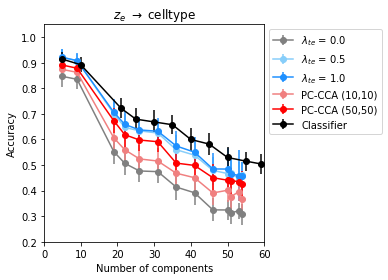

In [7]:
fiton_txt=['z_e']
for txt_ind,fiton in enumerate(['zE']):
    res_pth = '/home/rohan/Remote-AI/dat/result/Patchseq_NM_proc/'
    fname_list = ['QDA_{:s}_NM_aT_1-0_aE_1-0_cs_0-0_ad_0_ld_3_bs_200_se_500_ne_1500.csv'.format(fiton),\
                  'QDA_{:s}_NM_aT_1-0_aE_1-0_cs_0-5_ad_1_ld_3_bs_200_se_500_ne_1500.csv'.format(fiton),\
                  'QDA_{:s}_NM_aT_1-0_aE_1-0_cs_1-0_ad_1_ld_3_bs_200_se_500_ne_1500.csv'.format(fiton),\
                  'QDA_{:s}_PCCCA_NM_Edat_pcipfx_10-10-pc-3-cca.csv'.format(fiton),\
                  'QDA_{:s}_PCCCA_NM_Edat_pcipfx_50-50-pc-3-cca.csv'.format(fiton)]

    df_list = [pd.read_csv(res_pth+fname) for fname in fname_list]
    df_list.append(df)

    plt.figure(figsize=(5.5,4))
    col = ['gray',\
           'lightskyblue','dodgerblue',\
           'lightcoral','red','black']
    lbl = [r'$\lambda_{te}$ = 0.0',\
           r'$\lambda_{te}$ = 0.5',r'$\lambda_{te}$ = 1.0',\
           'PC-CCA (10,10)','PC-CCA (50,50)','Classifier']
    for i,df in enumerate(df_list):
        x_=[]
        y_=[]
        yerr_=[]
        for n in np.unique(df['n_components'].values):
            ind = df['n_components'].values==n
            x_.append(n)
            y_.append(np.mean(df['val_acc'].values[ind]))
            yerr_.append(np.std(df['val_acc'].values[ind]))
        plt.errorbar(x_,y_,yerr_,marker='o',color=col[i],label=lbl[i])

    
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    ax = plt.gca()
    ax.set_ylim(0.2,1.05)
    ax.set_xlim(0,60)
    ax.set_xlabel('Number of components')
    ax.set_ylabel('Accuracy')
    ax.set_title(r'${:s}$ $\rightarrow$ celltype'.format(fiton_txt[txt_ind]))
    
    plt.tight_layout()
    #plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/Rebuttal-{:s}-to-celltype.png'.format(fiton),dpi=300)
    

In [21]:
a,b = np.unique(lbl,return_counts=True)
for x in zip(a,b):print(x)

('Lamp5 Lsp1', 187)
('Lamp5 Plch2 Dock5', 176)
('Pvalb Reln Itm2a', 509)
('Pvalb Sema3e Kank4', 212)
('Sncg Vip Itih5', 149)
('Sst Calb2 Pdlim5', 419)
('Sst Chodl', 163)
('Sst Esm1', 194)
('Sst Hpse Cbln4', 286)
('Sst Rxfp1 Prdm8', 369)
('Sst Tac2 Tacstd2', 109)
('Vip Crispld2 Kcne4', 157)
('Vip Ptprt Pkp2', 259)
('Vip Pygm C1ql1', 222)


In [22]:
a,b = np.unique(O['cluster'],return_counts=True)
for x in zip(a,b):print(x)

('Lamp5 Fam19a1 Pax6', 5)
('Lamp5 Fam19a1 Tmem182', 14)
('Lamp5 Krt73', 1)
('Lamp5 Lhx6', 15)
('Lamp5 Lsp1', 158)
('Lamp5 Ntn1 Npy2r', 62)
('Lamp5 Plch2 Dock5', 130)
('Pvalb Akr1c18 Ntf3', 50)
('Pvalb Calb1 Sst', 21)
('Pvalb Gabrg1', 37)
('Pvalb Gpr149 Islr', 21)
('Pvalb Reln Itm2a', 203)
('Pvalb Reln Tac1', 33)
('Pvalb Sema3e Kank4', 152)
('Pvalb Th Sst', 40)
('Pvalb Tpbg', 148)
('Pvalb Vipr2', 17)
('Serpinf1 Aqp5 Vip', 14)
('Serpinf1 Clrn1', 1)
('Sncg Gpr50', 18)
('Sncg Slc17a8', 4)
('Sncg Vip Itih5', 83)
('Sncg Vip Nptx2', 24)
('Sst Calb2 Necab1', 42)
('Sst Calb2 Pdlim5', 237)
('Sst Chodl', 110)
('Sst Chrna2 Glra3', 16)
('Sst Chrna2 Ptgdr', 11)
('Sst Crh 4930553C11Rik ', 28)
('Sst Crhr2 Efemp1', 119)
('Sst Esm1', 112)
('Sst Hpse Cbln4', 199)
('Sst Hpse Sema3c', 49)
('Sst Mme Fam114a1', 39)
('Sst Myh8 Etv1 ', 43)
('Sst Myh8 Fibin', 13)
('Sst Nr2f2 Necab1', 27)
('Sst Nts', 36)
('Sst Rxfp1 Eya1', 87)
('Sst Rxfp1 Prdm8', 136)
('Sst Tac1 Htr1d', 63)
('Sst Tac1 Tacr3', 14)
('Sst Tac2 Myh4

In [54]:
O = sio.loadmat(base_path+'dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat',squeeze_me=True)
#Get merged ground truth labels
gt, orde   = get_merged_ordered_classes(data_labels=O['cluster'],htree_file=htree_file, n_required_classes=33)
cid = np.zeros(np.shape(gt),dtype=int)
idlut = list(zip(orde,range(33)))
for (lbl,i) in idlut:
    cid[gt==lbl]=i

Performed 27 merges. Remaining classes in data = 33


In [59]:
base_path='/home/rohan/Dropbox/AllenInstitute/CellTypes/'

In [60]:
sio.savemat(base_path+'dat/raw/patchseq-v4/ttype33.mat',{'cluster':gt,'cluster_id':cid})

# 33 way classification with different partitioning schemes
 - Autoencoder representations with QDA
 - 33 t-types as defined by merging Tasic hierarchy
 - 33 consensus types obtained by unsupervised clustering

In [1]:
import scipy.io as sio
from copy import deepcopy
from utils.tree_helpers import get_merged_ordered_classes
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import accuracy_score
from tqdm import tqdm

base_path = '/home/rohan/Remote-AI/'
htree_file = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/dend_RData_Tree_20181220.csv'
O = sio.loadmat(base_path+'dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat',squeeze_me=True)
n_classes = 33
n_min_samples = 10

#Keep only those labels in ground truth set that are well-sampled in the data
(lbl,counts) = np.unique(O['cluster'],return_counts = True)
kept_lbl = lbl[counts>n_min_samples]

print('{} cells discarded on removing ' \
       'poorly sampled classes'.format(np.sum(counts[counts<=10])))

#Find indices of cells that are not well-sampled:
low_sampled_ind = np.where(np.isin(O['cluster'],lbl[counts<=n_min_samples]))[0]

#merge the well sampled labels to get 33 classes.
merged_lbl, _   = get_merged_ordered_classes(data_labels=kept_lbl,htree_file=htree_file, n_required_classes=n_classes)
merged_labels = O['cluster'].copy()
for (old_lbl,new_lbl) in zip(kept_lbl,merged_lbl):
    merged_labels[merged_labels==old_lbl]=new_lbl
    
ttype33 = merged_labels.copy()

25 cells discarded on removing poorly sampled classes
Performed 22 merges. Remaining classes in data = 33


In [22]:
import scipy.io as sio
from copy import deepcopy
from utils.tree_helpers import get_merged_ordered_classes
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pickle

In [13]:
best_n_components = 33
base_path = '/home/rohan/Remote-AI/'
gmm_pth = base_path+'dat/result/TE_NM_cc/gmm_model_select_cv_0/'
representation_pth = base_path+'dat/result/TE_NM_cc/'

alpha_E = 1.0
alpha_T = 1.0
lambda_TE = 1.0
cv=0
aug=1
CVdict={}
ri_list = np.arange(0,21,1)
key_list = ['zE','zT','train_ind','val_ind','test_ind']


#Get all the cv folds - in this case the experiment is repeated runs on the same test set:
for ri in tqdm(ri_list):
    cvfold_fname='NM_Edat_pcipfx_aT_'+str(alpha_T)+\
            '_aE_'+str(alpha_E)+\
            '_cs_'+str(lambda_TE)+\
            '_ad_'+str(aug)+\
            '_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+\
            '_ri_'+str(ri)+\
            '_500_ft-summary'
    cvfold_fname=cvfold_fname.replace('.','-')+'.mat'
    X = sio.loadmat(representation_pth+cvfold_fname,squeeze_me=True)
    CVdict[ri] = {key:X[key] for key in key_list}
    del X

for ri in CVdict.keys():
    fname = 'gmmfit_restricted_perc_100-0_aT_{:.1f}_aE_{:.1f}_cs_{:.1f}_'\
            'ad_1_cv_0_ri_{:d}_ld_3_ne_1500_fiton_zT_n_{:d}'.format(alpha_T,alpha_E,lambda_TE,
                                                                 ri,best_n_components)
    
    fname = fname.replace('.','-')+'.pkl'
    with open(gmm_pth+fname, 'rb') as fid:
        gmm = pickle.load(fid)

    #Label predictions using GMM fits:
    CVdict[ri]['ccT_lbl'] = gmm.predict(CVdict[ri]['zT'])
    CVdict[ri]['ccE_lbl'] = gmm.predict(CVdict[ri]['zE'])

100%|██████████| 21/21 [00:04<00:00,  4.41it/s]


In [14]:
consensus33_labels = CVdict[11]['ccE_lbl']

#### Classification accuracy with autoencoder representations and QDA using 33 t-types

In [15]:
lambda_TE = 0.0
aug = 0
for ri in tqdm(ri_list):
    cvfold_fname='NM_Edat_pcipfx_aT_'+str(alpha_T)+\
            '_aE_'+str(alpha_E)+\
            '_cs_'+str(lambda_TE)+\
            '_ad_'+str(aug)+\
            '_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+\
            '_ri_'+str(ri)+\
            '_500_ft-summary'
    cvfold_fname=cvfold_fname.replace('.','-')+'.mat'
    X = sio.loadmat(representation_pth+cvfold_fname,squeeze_me=True)
    CVdict[ri] = {key:X[key] for key in key_list}
    del X

100%|██████████| 21/21 [00:04<00:00,  4.53it/s]


In [23]:

for exp in ['ttype33','consensus33']:
    acc_val = []
    acc_train = []
    acc_test = []
    n_components_list=[]
    fiton = 'zE'
    for cv in tqdm(CVdict.keys()):
        D = CVdict[cv]

        #merged_labels=ttype33
        if exp=='ttype33':
            merged_labels=ttype33
        
        elif exp=='consensus33':
            #merged_labels=CVdict[11]['ccE_lbl']
            merged_labels=consensus33_labels

        X_train = deepcopy(D[fiton][D['train_ind']])
        y_train = deepcopy(merged_labels[D['train_ind']])
        ind_train = np.arange(0,np.shape(X_train)[0])

        X_val   = deepcopy(D[fiton][D['val_ind']])
        y_val   = deepcopy(merged_labels[D['val_ind']])
        ind_val = np.arange(0,np.shape(X_val)[0])

        X_test   = deepcopy(D[fiton][D['test_ind']])
        y_test   = deepcopy(merged_labels[D['test_ind']])
        ind_test = np.arange(0,np.shape(X_test)[0])

        #Remove types with low sample counts in training set
        df = pd.DataFrame({'ind':ind_train,'lbl':y_train})
        df_train = df[df.groupby('lbl')['lbl'].transform('count').ge(n_min_samples)]
        keep_ind = df_train['ind'].values
        X_train = X_train[keep_ind,:]
        y_train = y_train[keep_ind]

        #Print types that were removed
        #df_train_del = df[df.groupby('lbl')['lbl'].transform('count').lt(n_min_samples)]
        #print(df_train_del['lbl'].value_counts())

        #Remove types from validation set that are not represented in the training set
        df = pd.DataFrame({'ind':ind_val,'lbl':y_val})
        df_val = df[df['lbl'].isin(y_train)]
        keep_ind = df_val['ind'].values
        X_val = X_val[keep_ind,:]
        y_val = y_val[keep_ind]

        #Remove types from test set that are not represented in the training set
        df = pd.DataFrame({'ind':ind_test,'lbl':y_test})
        df_test = df[df['lbl'].isin(y_test)]
        keep_ind = df_test['ind'].values
        X_test = X_test[keep_ind,:]
        y_test = y_test[keep_ind]

        #QDA related metrics
        n_lbls = np.size(np.unique(y_train))
        qda = QDA(reg_param=1e-2,store_covariance=True)
        qda.fit(X_train,y_train)
        y_train_pred = qda.predict(X_train)
        y_val_pred = qda.predict(X_val)
        y_test_pred = qda.predict(X_test)
        n_components_list.append(np.unique(qda.classes_).size)
        
        #Linear classifier related metrics
#         LR = LogisticRegression(solver='saga')
        LR = LDA()
        LR.fit(X_train,y_train)
        y_train_pred = LR.predict(X_train)
        y_val_pred = LR.predict(X_val)
        y_test_pred = LR.predict(X_test)
        n_components_list.append(np.unique(LR.classes_).size)
        
        acc_train.append(accuracy_score(y_train, y_train_pred))
        acc_val.append(accuracy_score(y_val, y_val_pred))
        acc_test.append(accuracy_score(y_test, y_test_pred))
    print('{} classification accuracy mean: {:0.3f} sd: {:0.3f}'.format(exp,np.mean(acc_val),np.std(acc_val)))

 14%|█▍        | 3/21 [00:00<00:00, 20.01it/s]

ttype33 classification accuracy mean: 0.390 sd: 0.028


100%|██████████| 21/21 [00:01<00:00, 19.95it/s]

consensus33 classification accuracy mean: 0.392 sd: 0.019


In [6]:
(a,b) = np.unique(O['cluster'],return_counts=True)
for x in zip(a,b): print(x)

('Lamp5 Fam19a1 Pax6', 5)
('Lamp5 Fam19a1 Tmem182', 14)
('Lamp5 Krt73', 1)
('Lamp5 Lhx6', 15)
('Lamp5 Lsp1', 158)
('Lamp5 Ntn1 Npy2r', 62)
('Lamp5 Plch2 Dock5', 130)
('Pvalb Akr1c18 Ntf3', 50)
('Pvalb Calb1 Sst', 21)
('Pvalb Gabrg1', 37)
('Pvalb Gpr149 Islr', 21)
('Pvalb Reln Itm2a', 203)
('Pvalb Reln Tac1', 33)
('Pvalb Sema3e Kank4', 152)
('Pvalb Th Sst', 40)
('Pvalb Tpbg', 148)
('Pvalb Vipr2', 17)
('Serpinf1 Aqp5 Vip', 14)
('Serpinf1 Clrn1', 1)
('Sncg Gpr50', 18)
('Sncg Slc17a8', 4)
('Sncg Vip Itih5', 83)
('Sncg Vip Nptx2', 24)
('Sst Calb2 Necab1', 42)
('Sst Calb2 Pdlim5', 237)
('Sst Chodl', 110)
('Sst Chrna2 Glra3', 16)
('Sst Chrna2 Ptgdr', 11)
('Sst Crh 4930553C11Rik ', 28)
('Sst Crhr2 Efemp1', 119)
('Sst Esm1', 112)
('Sst Hpse Cbln4', 199)
('Sst Hpse Sema3c', 49)
('Sst Mme Fam114a1', 39)
('Sst Myh8 Etv1 ', 43)
('Sst Myh8 Fibin', 13)
('Sst Nr2f2 Necab1', 27)
('Sst Nts', 36)
('Sst Rxfp1 Eya1', 87)
('Sst Rxfp1 Prdm8', 136)
('Sst Tac1 Htr1d', 63)
('Sst Tac1 Tacr3', 14)
('Sst Tac2 Myh4

**Testing HDBSCAN performance** 

In [1]:
import hdbscan
import pickle
import scipy.io as sio
from sklearn.decomposition import PCA
import seaborn as sns
sns.set()

In [2]:
base_path = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/'

#These CVsets are multiple runs with the same test set.
with open(base_path+'dat/temp/CVsets.pkl', 'rb') as f:
    CVdict = pickle.load(f)

O = sio.loadmat(base_path+'dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat',squeeze_me=True)

#Choose data from the run shown in the manuscript:
x = CVdict[11]['zT']

In [3]:
#min_samples has a major impact clustering, is inherited from DBSCAN.
#See: https://hdbscan.readthedocs.io/_/downloads/en/0.8.12/pdf/
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, 
                            min_samples=1,
                            cluster_selection_method='leaf',
                            gen_min_span_tree=True)
clusterer.fit(x)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='leaf', core_dist_n_jobs=4,
        gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=10, min_samples=1, p=None,
        prediction_data=False)

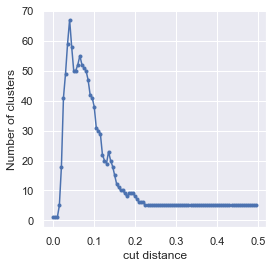

In [4]:

n_clusters = []
d_range = np.arange(0,0.5,0.005)
for d in d_range:
    labels = clusterer.single_linkage_tree_.get_clusters(cut_distance=d)
    n_clusters.append(np.unique(labels).size)

%matplotlib inline
plt.figure(figsize=(4,4))
plt.plot(d_range,n_clusters,'.-')
ax = plt.gca()
ax.set_xlabel('cut distance')
ax.set_ylabel('Number of clusters')
plt.show()

n clusters = 51, cut distance = 0.075


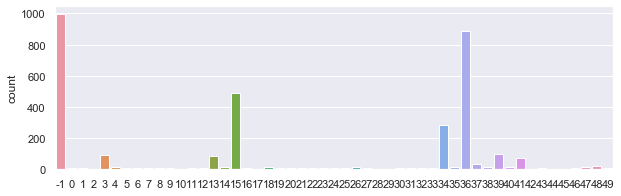

In [5]:
ind = np.abs(np.array(n_clusters) - (50+1)).argmin()
d_chosen = d_range[ind]
labels = clusterer.single_linkage_tree_.get_clusters(cut_distance=d_chosen)
print(f'n clusters = {np.unique(labels).size}, cut distance = {d_chosen:0.3f}')

plt.figure(figsize=(10,3))
sns.countplot(x=labels)
plt.show()

In [6]:
color_palette = sns.color_palette('Paired', np.unique(labels).size)
cluster_colors = [color_palette[lbl] if lbl >= 0
                  else (0.5, 0.5, 0.5)
                  for lbl in labels]
cluster_member_colors = [sns.desaturate(x_, p_) for x_, p_ in
                         zip(cluster_colors, clusterer.probabilities_)]

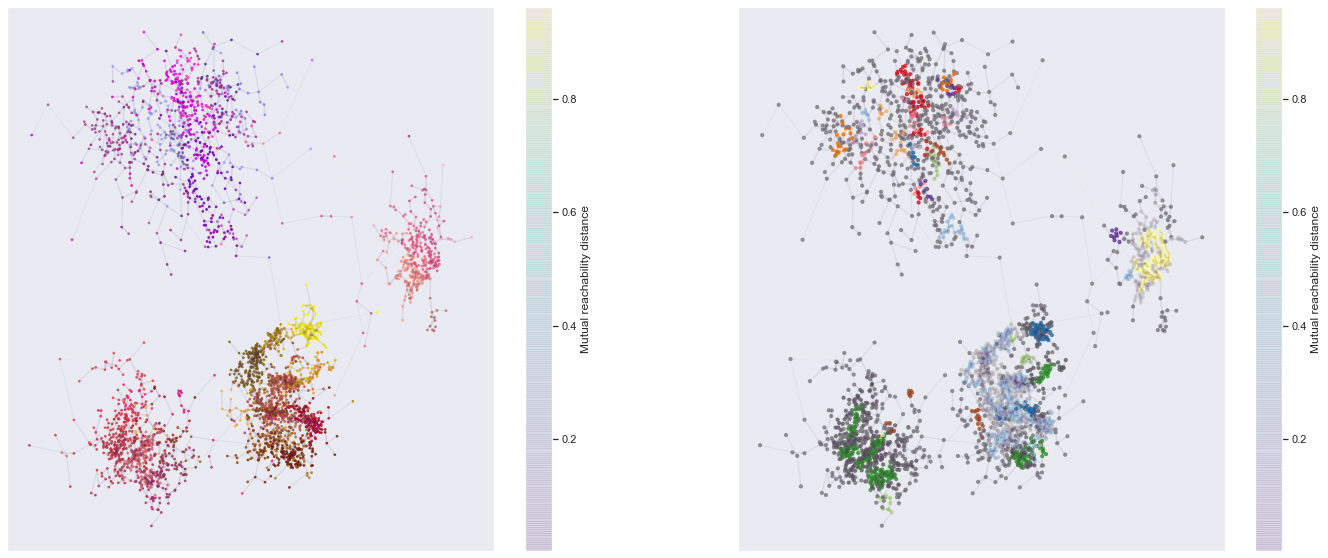

In [7]:
%matplotlib inline
plt.figure(figsize=(24,10))
plt.subplot(121)
 #To avoid using t-sne projection while plotting. 
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.1,
                                      node_size=3,
                                      edge_linewidth=0.5,
                                      node_color=O['cluster_color'])

#Plot with DBSCAN cluster colors
plt.subplot(122)
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.1,
                                      node_size=10,
                                      edge_linewidth=0.5,
                                      node_color=cluster_member_colors)

plt.show()

In [18]:
from refactor.utils.plots import matrix_scatterplot,contingency
from refactor.utils.tree_helpers import get_merged_ordered_classes
from scipy.optimize import linear_sum_assignment

Performed 0 merges. Remaining classes in data = 59


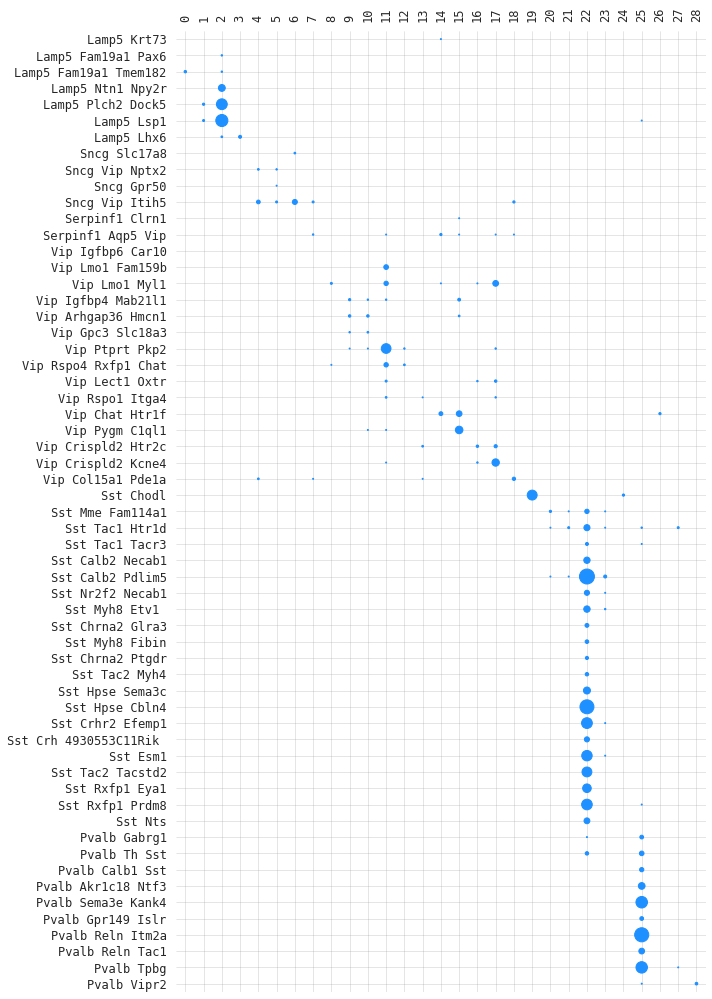

In [19]:
n_required_classes = np.unique(O['cluster']).size
t_type_labels,t_types = get_merged_ordered_classes(data_labels=O['cluster'].copy(),
                                                   htree_file='./refactor/data/proc/dend_RData_Tree_20181220.csv',
                                                   n_required_classes=n_required_classes)

n_components = np.max(labels)
C = contingency(t_type_labels, labels, t_types, np.arange(n_components))
row_ind,col_ind = linear_sum_assignment(-C)
C_ordered = C[:,col_ind]
order_y = np.arange(0,n_components)[col_ind]

matrix_scatterplot(C_ordered,xticklabels=np.arange(n_components),yticklabels=t_types,scale_factor=1)

# Checking ARI for 33 way classifiers:

 - Tasic 33 way labels are more unbalanced than GMM clustering labels
 - Accuracy can therefore be higher with Tasic labels despite poor performance.

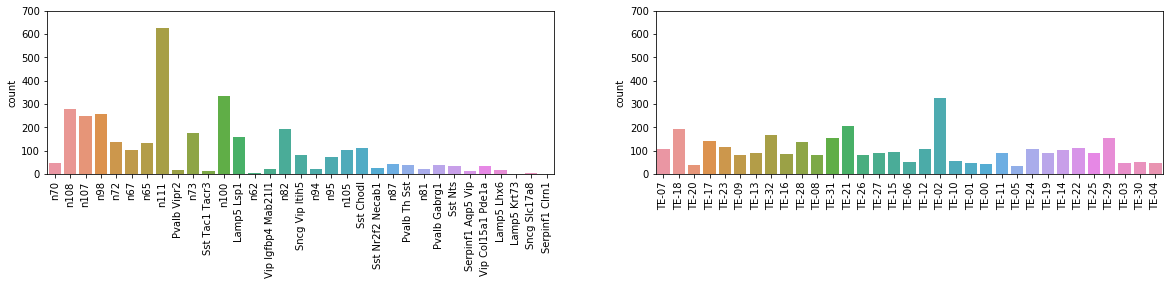

In [1]:
import scipy.io as sio
from sklearn.metrics import adjusted_rand_score
import seaborn as sns

ttype33 = sio.loadmat('/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/ttype33.mat',squeeze_me=True)
consensus33 = sio.loadmat('/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/consensus_cluster.mat',squeeze_me=True)

plt.figure(figsize=(20,3))
plt.subplot(121)
ax = sns.countplot(ttype33['cluster'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim(0,700)

plt.subplot(122)
ax = sns.countplot(consensus33['consensus_cluster'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim(0,700)
plt.show()

In [3]:
base_path = '/home/rohan/Remote-AI/'
O = sio.loadmat(base_path+'dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat',squeeze_me=True)
ld = 3

for gt_ in ['ttype33','consensus']:
    if gt_ == 'ttype33':
        gt = ttype33['cluster']
    elif gt_ == 'consensus':
        gt = consensus33['consensus_cluster']
        
    df = {}
    df['val_acc']=[]
    df['val_ari']=[]
    df['n_components']=[]
    pred_list=[]
    gt_list=[]
    n_components=33
    for cv in range(44):

        D = sio.loadmat(base_path+f'dat/result/E_classifiers/best_v1_gt_{gt_}_bs_200_se_500_ne_1000_ld_{ld:d}_cv_{cv:d}_ri_0-summary.mat', squeeze_me=True)
        ind = D['val_ind'].copy()
        train_ind = D['train_ind'].copy()

        #Clean up format of the strings in the label array
        pred = D['pred_E_cat'].copy().tolist()
        pred = [x.lstrip() for x in pred]
        pred = [x.rstrip() for x in pred]
        pred = np.array(pred)
        pred = pred.astype(np.object_).copy()

        pred_list.append(pred[ind])
        gt_list.append(gt[ind])

        df['val_ari'].append(adjusted_rand_score(gt[ind],pred[ind]))
        df['val_acc'].append(np.sum(pred[ind]==gt[ind])/ind.size)
        df['n_components'].append(n_components)
        
        print(np.unique(pred[train_ind]).size)

    pred_arr = np.concatenate(pred_list)
    gt_arr = np.concatenate(gt_list)
    overall_acc = np.sum(gt_arr==pred_arr)/pred_arr.size
    overall_ari = adjusted_rand_score(gt_arr,pred_arr)
    print(f'\n {gt_} ====')
    
    print(f'ARI: {overall_ari:0.3f} ACC: {overall_acc:0.3f}')
    x=np.mean(df['val_ari'])
    y=np.mean(df['val_acc'])
    print(f'ARI: {x:0.3f} ACC: {y:0.3f}')
    print(np.unique(pred_arr).shape)

10
12
13
14
10
14
13
11
13
12
12
11
12
12
12
11
11
12
10
12
10
11
12
13
10
13
12
11
14
12
11
13
12
14
12
12
12
12
12
11
12
14
12
13

 ttype33 ====
ARI: 0.654 ACC: 0.713
ARI: 0.637 ACC: 0.713
(16,)
15
17
14
15
13
15
17
17
16
16
16
16
15
14
15
15
15
15
15
16
16
16
14
18
15
18
14
16
15
16
15
16
18
16
15
15
16
15
15
16
17
18
15
17

 consensus ====
ARI: 0.443 ACC: 0.535
ARI: 0.421 ACC: 0.535
(26,)


# Dataset for E classifier experiments

In [1]:
import scipy.io as sio
from refactor.utils.tree_helpers import get_merged_ordered_classes

min_sample_count=10

consensus33 = sio.loadmat('/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/consensus_cluster.mat',squeeze_me=True)
O = sio.loadmat('/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat',squeeze_me=True)
(labels,counts) = np.unique(O['cluster'],return_counts=True)
keep_labels = labels[counts>min_sample_count]
keep_ind = np.isin(O['cluster'],keep_labels)
sum(keep_ind)

3386

In [2]:
D = {}
D['E_pc_scaled'] = O['E_pc_scaled'][keep_ind,:]
D['E_feature'] = O['E_feature'][keep_ind,:]
D['E_spec_id_label'] = O['E_spec_id_label'][keep_ind]

D['cluster'] = O['cluster'][keep_ind]
D['cluster_id'] = O['cluster_id'][keep_ind]

D['consensus33'] = consensus33['consensus_cluster'][keep_ind]
D['consensus33_id'] = np.zeros(D['consensus33'].shape,dtype=int)
for i,l in enumerate(np.unique(D['consensus33'])):
    D['consensus33_id'][D['consensus33']==l] = i

D['ttype33'],ttype33_order = get_merged_ordered_classes(data_labels=D['cluster'].copy(),
                           htree_file='/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/dend_RData_Tree_20181220.csv',
                           n_required_classes=33)
D['ttype33_id'] = np.zeros(D['ttype33'].shape,dtype=int)
for i,l in enumerate(ttype33_order):
    D['ttype33_id'][D['ttype33']==l] = i

Performed 22 merges. Remaining classes in data = 33


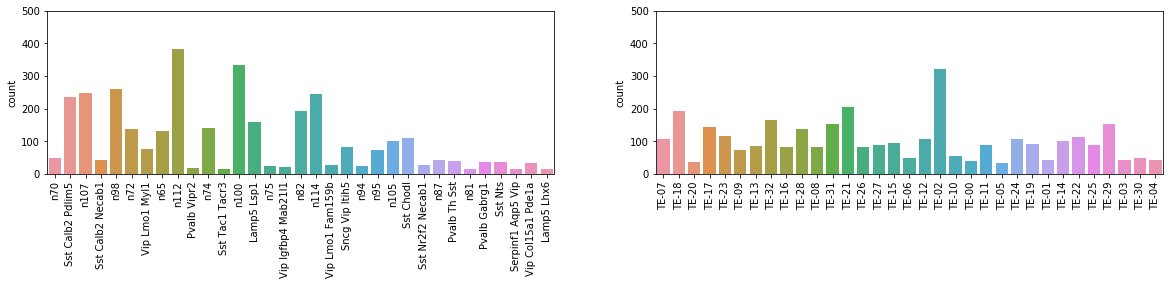

In [3]:
plt.figure(figsize=(20,3))
plt.subplot(121)
ax = sns.countplot(D['ttype33'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim(0,500)

plt.subplot(122)
ax = sns.countplot(D['consensus33'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim(0,500)
plt.show()

In [4]:
sio.savemat('/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/E_classifier_data.mat',mdict=D)

In [1]:
import scipy.io as sio
import pandas as pd
from copy import deepcopy 
import seaborn as sns
sns.set()

In [2]:
base_path = '/home/rohan/Remote-AI/'
for gt in ['ttype33','consensus33']:
    print(f'\n{gt} ====')
    for ld in [3,5,10]:
        best_acc_list = []
        for cv in np.arange(0,10,1):
            R = pd.read_csv(base_path+f'/dat/result/E_classifiers_v2/logs/v2_gt_{gt}_bs_200_se_500_ne_1000_ld_{ld:d}_cv_{cv:d}_by_{gt}_ri_0.csv')
            best_acc_list.append(np.max(R['val_acc'].values))
        print('latent dim: {:02d} mean: {:0.3f} sd: {:0.3f}'.format(ld, np.mean(best_acc_list), np.std(best_acc_list)))


ttype33 ====
latent dim: 03 mean: 0.390 sd: 0.037
latent dim: 05 mean: 0.519 sd: 0.037
latent dim: 10 mean: 0.604 sd: 0.026

consensus33 ====
latent dim: 03 mean: 0.367 sd: 0.027
latent dim: 05 mean: 0.486 sd: 0.016
latent dim: 10 mean: 0.564 sd: 0.017


In [4]:
O = sio.loadmat(base_path+f'dat/raw/patchseq-v4/E_classifier_data.mat',squeeze_me=True)


for gt in ['ttype33','consensus33']:
    print(f'\n{gt} ====')
    for ld in [3,5,10]:
        best_acc_list = []
        true_lbl = []
        pred_lbl = []
        
        #Collect labels for all cv sets
        acc_list_cv_avg = []
        for cv in np.arange(0,10,1):
            D = sio.loadmat(base_path+f'dat/result/E_classifiers_v2/best_v2_gt_{gt}_bs_200_se_500_ne_1000_ld_{ld:d}_cv_{cv:d}_by_{gt}_ri_0-summary.mat',squeeze_me=True)

            val_ind = D['val_ind']
            true_lbl_cv = O[gt][val_ind]
            pred_lbl_cv = D['pred_E_cat'][val_ind]
            true_lbl.append(true_lbl_cv)
            pred_lbl.append(pred_lbl_cv)
            
            acc_list_cv=[]
            #Calculate acc for each label for this cv
            for lbl in np.unique(O[gt]):
                true_count = np.sum(true_lbl_cv==lbl)
                pred_count = np.sum(pred_lbl_cv[true_lbl_cv==lbl]==lbl)
                acc_ = pred_count/true_count
                acc_list_cv.append(acc_)
            #print(f'avg classwise acc in fold {cv}: {np.mean(acc_list_cv):0.3f}')
            acc_list_cv_avg.append(np.mean(acc_list_cv))
            
        true_lbl = np.concatenate(true_lbl)
        pred_lbl = np.concatenate(pred_lbl)
        
        
        #Collect label wise accuracy
        acc_list = []
        for lbl in np.unique(O[gt]):
            true_count = np.sum(true_lbl==lbl)
            pred_count = np.sum(pred_lbl[true_lbl==lbl]==lbl)
            acc = pred_count/true_count
            acc_list.append(acc)
            if pred_count==0:
                pass
                #print(f'No correctly predicted samples for {lbl:20s} with {true_count} samples')
        print(f'{ld:2d} dim average classwise acc: {np.mean(acc_list):0.3f}, unique classes {np.unique(pred_lbl).size}, avg. over cv folds: {np.mean(acc_list_cv_avg):0.3f}+{np.std(acc_list_cv_avg):0.3f}')


ttype33 ====
 3 dim average classwise acc: 0.383, unique classes 32, avg. over cv folds: 0.390+0.037
 5 dim average classwise acc: 0.510, unique classes 33, avg. over cv folds: 0.519+0.037
10 dim average classwise acc: 0.602, unique classes 33, avg. over cv folds: 0.604+0.026

consensus33 ====
 3 dim average classwise acc: 0.368, unique classes 32, avg. over cv folds: 0.367+0.027
 5 dim average classwise acc: 0.485, unique classes 31, avg. over cv folds: 0.486+0.016
10 dim average classwise acc: 0.563, unique classes 31, avg. over cv folds: 0.564+0.017


In [79]:
acc_list_cv_avg

[0.5743010381379365]